### **House Sales Time Series**

### Importing Lib's

In [191]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller

### Loading Data

In [192]:
data = pd.read_csv("raw_sales.csv")
data.head()

,datesold,postcode,price,propertyType,bedrooms
0,2007-02-07 00:00:00,2607,525000,house,4
1,2007-02-27 00:00:00,2906,290000,house,3
2,2007-03-07 00:00:00,2905,328000,house,3
3,2007-03-09 00:00:00,2905,380000,house,4
4,2007-03-21 00:00:00,2906,310000,house,3


In [193]:
data.shape

(29580, 5)

In [194]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29580 entries, 0 to 29579
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   datesold      29580 non-null  object
 1   postcode      29580 non-null  int64 
 2   price         29580 non-null  int64 
 3   propertyType  29580 non-null  object
 4   bedrooms      29580 non-null  int64 
dtypes: int64(3), object(2)
memory usage: 1.1+ MB


#### Converting to the right data type

In [195]:
data['datesold'] = pd.to_datetime(data['datesold'])

In [196]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29580 entries, 0 to 29579
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   datesold      29580 non-null  datetime64[ns]
 1   postcode      29580 non-null  int64         
 2   price         29580 non-null  int64         
 3   propertyType  29580 non-null  object        
 4   bedrooms      29580 non-null  int64         
dtypes: datetime64[ns](1), int64(3), object(1)
memory usage: 1.1+ MB


#### Performing EDA

In [197]:
data["propertyType"].unique()

array(['house', 'unit'], dtype=object)

In [198]:
data["postcode"].unique()

array([2607, 2906, 2905, 2606, 2902, 2612, 2904, 2615, 2914, 2602, 2600,
       2605, 2603, 2611, 2903, 2617, 2913, 2604, 2614, 2912, 2601, 2900,
       2620, 2618, 2616, 2911, 2609], dtype=int64)

In [199]:
data.duplicated().sum()

0

#### Setting Data As The Index For Plotting 

In [200]:
data_indexed = data.set_index("datesold")
data_indexed.head(10)

,postcode,price,propertyType,bedrooms
datesold,,,,
2007-02-07,2607,525000,house,4
2007-02-27,2906,290000,house,3
2007-03-07,2905,328000,house,3
2007-03-09,2905,380000,house,4
2007-03-21,2906,310000,house,3
2007-04-04,2905,465000,house,4
2007-04-24,2607,399000,house,3
2007-04-30,2606,1530000,house,4
2007-05-24,2902,359000,house,3


In [201]:
# Visualize the data
# plt.figure(figsize=(10, 6))
# sns.lineplot(x=data_indexed.index, y=data_indexed['price'])
# plt.title('House Price Over Time')
# plt.xlabel('Date')
# plt.ylabel('Price')
# plt.show()

In [202]:
data_indexed.shape

(29580, 4)

In [203]:
import prophet as pt

#### Preparing For Prophet Model

In [204]:
data[["datesold", "price"]]

,datesold,price
0,2007-02-07,525000
1,2007-02-27,290000
2,2007-03-07,328000
3,2007-03-09,380000
4,2007-03-21,310000
...,...,...
29575,2019-07-25,500000
29576,2019-07-25,560000
29577,2019-07-26,464950
29578,2019-07-26,589000


In [205]:
prop_data = pd.DataFrame(data=data[["datesold", "price"]])
prop_data.rename(columns={'datesold':'ds', 'price':'y'}, inplace=True)
prop_data.head()

,ds,y
0,2007-02-07,525000
1,2007-02-27,290000
2,2007-03-07,328000
3,2007-03-09,380000
4,2007-03-21,310000


In [206]:
prop_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29580 entries, 0 to 29579
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   ds      29580 non-null  datetime64[ns]
 1   y       29580 non-null  int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 462.3 KB


### Resampling and Interpolating the data to make it consistent

In [207]:
# Set the date column as index
prop_data.set_index('ds', inplace=True)

# Resample to hourly frequency
df_resampled = prop_data.resample('D').mean()

df_interpolated = df_resampled.interpolate(method='time')


In [208]:
df_prophet = df_interpolated.reset_index()
df_prophet.columns = ['ds', 'y']


In [209]:
df_prophet.shape

(4554, 2)

Stationary Check (if p-value is lower 0.05 the data is stationary)

In [210]:
# Check for stationarity
result = adfuller(df_prophet['y'])
print('ADF Statistic:', result[0])
print('p-value:', result[1])

ADF Statistic: -8.414230775000636
p-value: 2.064381514043946e-13


In [211]:
tes_ = data.reset_index()
_tes = df_prophet.reset_index()
print(tes_)
ck_df = pd.DataFrame({"main":tes_['datesold'].tail(10), "resampled":_tes['ds'].tail(10)})
ck_df

       index   datesold  postcode   price propertyType  bedrooms
0          0 2007-02-07      2607  525000        house         4
1          1 2007-02-27      2906  290000        house         3
2          2 2007-03-07      2905  328000        house         3
3          3 2007-03-09      2905  380000        house         4
4          4 2007-03-21      2906  310000        house         3
...      ...        ...       ...     ...          ...       ...
29575  29575 2019-07-25      2900  500000         unit         3
29576  29576 2019-07-25      2612  560000         unit         2
29577  29577 2019-07-26      2912  464950         unit         2
29578  29578 2019-07-26      2601  589000         unit         2
29579  29579 2019-07-26      2612  775000         unit         2

[29580 rows x 6 columns]


,main,resampled
4544,NaT,2019-07-18
4545,NaT,2019-07-19
4546,NaT,2019-07-20
4547,NaT,2019-07-21
4548,NaT,2019-07-22
4549,NaT,2019-07-23
4550,NaT,2019-07-24
4551,NaT,2019-07-25
4552,NaT,2019-07-26
4553,NaT,2019-07-27


#### Splitting  the dataset

In [212]:
test_len = int(len(df_prophet) * 0.2)
train_len = int(len(df_prophet) * 0.8)
train = df_prophet[:train_len]
test = df_prophet[train_len:]
print(test_len)

910


In [213]:
train = train.drop_duplicates()

In [214]:
len(train)

3643

In [215]:
test = test.drop_duplicates()
test 

,ds,y
3643,2017-01-28,627375.000000
3644,2017-01-29,578182.500000
3645,2017-01-30,528990.000000
3646,2017-01-31,600227.272727
3647,2017-02-01,564529.411765
...,...,...
4549,2019-07-23,562123.333333
4550,2019-07-24,482500.000000
4551,2019-07-25,547800.000000
4552,2019-07-26,594408.333333


In [216]:
len(test)

911

#### Initialize the model

In [217]:
model = pt.Prophet()
model.fit(train)

19:24:31 - cmdstanpy - INFO - Chain [1] start processing
19:24:34 - cmdstanpy - INFO - Chain [1] done processing


In [218]:
future = model.make_future_dataframe(len(test), include_history=False)
future

,ds
0,2017-01-28
1,2017-01-29
2,2017-01-30
3,2017-01-31
4,2017-02-01
...,...
906,2019-07-23
907,2019-07-24
908,2019-07-25
909,2019-07-26


In [219]:
forecast = model.predict(future)
forecast[['ds', 'yhat', 'yhat_lower',
          'yhat_upper', 'trend',
          'trend_lower', 'trend_upper']].tail(10)

,ds,yhat,yhat_lower,yhat_upper,trend,trend_lower,trend_upper
901,2019-07-18,708743.484382,509061.052647,9.081450e+05,711943.779087,643937.445696,777931.940109
902,2019-07-19,721245.918604,506414.315880,9.321588e+05,712011.598027,643874.479850,778101.975992
903,2019-07-20,819788.245118,602417.184153,1.019698e+06,712079.416968,643811.514004,778272.011876
904,2019-07-21,784919.495841,577087.220896,9.902236e+05,712147.235909,643748.548158,778442.047759
905,2019-07-22,722758.798990,512010.145234,9.207874e+05,712215.054850,643685.582312,778612.083642
906,2019-07-23,712065.311081,509981.053043,9.214327e+05,712282.873791,643622.616466,778782.119525
907,2019-07-24,723070.503335,518082.331901,9.292284e+05,712350.692732,643559.650620,778952.155408
908,2019-07-25,718302.474930,509937.236766,9.151353e+05,712418.511673,643496.684774,779122.191292
909,2019-07-26,726453.085187,516885.266947,9.284510e+05,712486.330613,643433.718928,779302.187285
910,2019-07-27,820619.149720,607598.184919,1.017947e+06,712554.149554,643370.753082,779555.934449


In [220]:
forecast.columns

Index(['ds', 'trend', 'yhat_lower', 'yhat_upper', 'trend_lower', 'trend_upper',
       'additive_terms', 'additive_terms_lower', 'additive_terms_upper',
       'weekly', 'weekly_lower', 'weekly_upper', 'yearly', 'yearly_lower',
       'yearly_upper', 'multiplicative_terms', 'multiplicative_terms_lower',
       'multiplicative_terms_upper', 'yhat'],
      dtype='object')

d:\my files\data sci\.env\Lib\site-packages\prophet\plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
d:\my files\data sci\.env\Lib\site-packages\prophet\plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


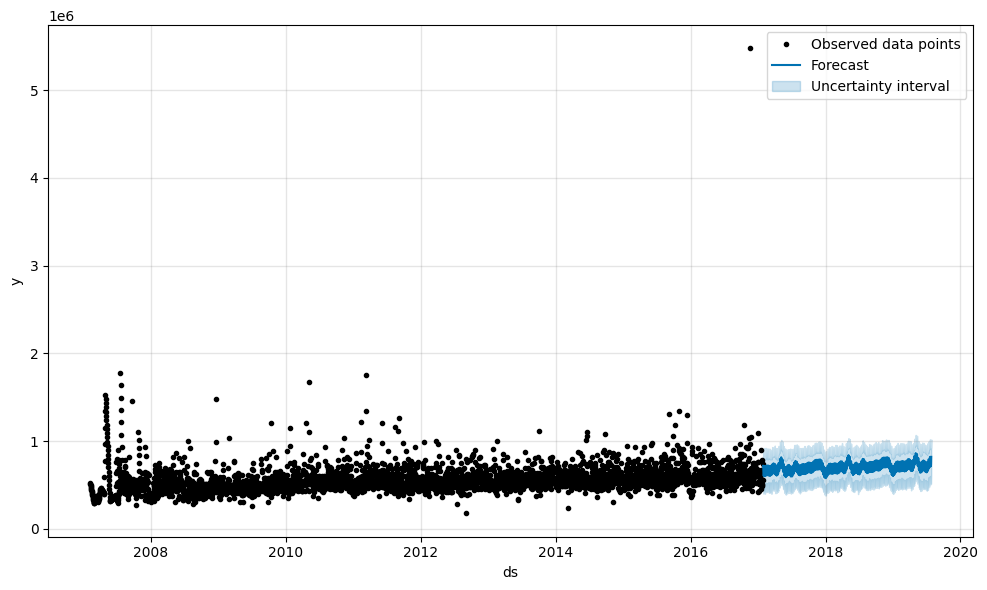

In [221]:
fig1 = model.plot(forecast, include_legend=True)


In [222]:
test = test.reset_index(drop=True)
test

,ds,y
0,2017-01-28,627375.000000
1,2017-01-29,578182.500000
2,2017-01-30,528990.000000
3,2017-01-31,600227.272727
4,2017-02-01,564529.411765
...,...,...
906,2019-07-23,562123.333333
907,2019-07-24,482500.000000
908,2019-07-25,547800.000000
909,2019-07-26,594408.333333


In [223]:
train

,ds,y
0,2007-02-07,525000.000000
1,2007-02-08,513250.000000
2,2007-02-09,501500.000000
3,2007-02-10,489750.000000
4,2007-02-11,478000.000000
...,...,...
3638,2017-01-23,496528.947368
3639,2017-01-24,506750.000000
3640,2017-01-25,738000.000000
3641,2017-01-26,645428.571429


In [224]:
forecast.shape

(911, 19)

In [232]:
evalution_df = pd.DataFrame(
    {
        'date':test['ds'],
        'actual':test['y'],
        'predicted':forecast['yhat'],
        'test - forecast':test['y'] - forecast['yhat'],
        'upper_bound':forecast['yhat_upper'],
        'diff_2':test['y'] - forecast['yhat_upper'],
        'lower_bound':forecast['yhat_lower'],
        'diff_3':test['y'] - forecast['yhat_lower'],
    }
)

In [233]:
evalution_df

,date,actual,predicted,test - forecast,upper_bound,diff_2,lower_bound,diff_3
0,2017-01-28,627375.000000,718008.348176,-90633.348176,9.081901e+05,-280815.085272,522631.521809,104743.478191
1,2017-01-29,578182.500000,680454.062172,-102271.562172,8.669048e+05,-288722.323901,491193.637659,86988.862341
2,2017-01-30,528990.000000,616213.025431,-87223.025431,8.061299e+05,-277139.937986,401515.397072,127474.602928
3,2017-01-31,600227.272727,604107.829369,-3880.556642,8.049550e+05,-204727.697129,421377.162550,178850.110177
4,2017-02-01,564529.411765,614414.049231,-49884.637466,8.128853e+05,-248355.901943,420314.699607,144214.712157
...,...,...,...,...,...,...,...,...
906,2019-07-23,562123.333333,712065.311081,-149941.977747,9.214327e+05,-359309.318838,509981.053043,52142.280290
907,2019-07-24,482500.000000,723070.503335,-240570.503335,9.292284e+05,-446728.401242,518082.331901,-35582.331901
908,2019-07-25,547800.000000,718302.474930,-170502.474930,9.151353e+05,-367335.341321,509937.236766,37862.763234
909,2019-07-26,594408.333333,726453.085187,-132044.751854,9.284510e+05,-334042.688769,516885.266947,77523.066386


find the percentage by which the forecast is greater than the actual

In [227]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [228]:
# Calculate accuracy metrics
mae = mean_absolute_error(test['y'], forecast['yhat'])
mse = mean_squared_error(test['y'], forecast['yhat'])
rmse = np.sqrt(mse)

print(f'Mean Absolute Error (MAE): {mae:.2f}')
print(f'Mean Squared Error (MSE): {mse:.2f}')
print(f'Root Mean Squared Error (RMSE): {rmse:.2f}')

Mean Absolute Error (MAE): 95120.44
Mean Squared Error (MSE): 19869127722.08
Root Mean Squared Error (RMSE): 140957.89


In [229]:
# Calculate accuracy metrics
mae = mean_absolute_error(test['y'], forecast['yhat_upper'])
mse = mean_squared_error(test['y'], forecast['yhat_upper'])
rmse = np.sqrt(mse)

print(f'Mean Absolute Error (MAE): {mae:.2f}')
print(f'Mean Squared Error (MSE): {mse:.2f}')
print(f'Root Mean Squared Error (RMSE): {rmse:.2f}')

Mean Absolute Error (MAE): 234112.94
Mean Squared Error (MSE): 67025307394.57
Root Mean Squared Error (RMSE): 258892.46


In [230]:
# Calculate accuracy metrics
mae = mean_absolute_error(test['y'], forecast['yhat_lower'])
mse = mean_squared_error(test['y'], forecast['yhat_lower'])
rmse = np.sqrt(mse)

print(f'Mean Absolute Error (MAE): {mae:.2f}')
print(f'Mean Squared Error (MSE): {mse:.2f}')
print(f'Root Mean Squared Error (RMSE): {rmse:.2f}')

Mean Absolute Error (MAE): 181826.94
Mean Squared Error (MSE): 50173989893.71
Root Mean Squared Error (RMSE): 223995.51


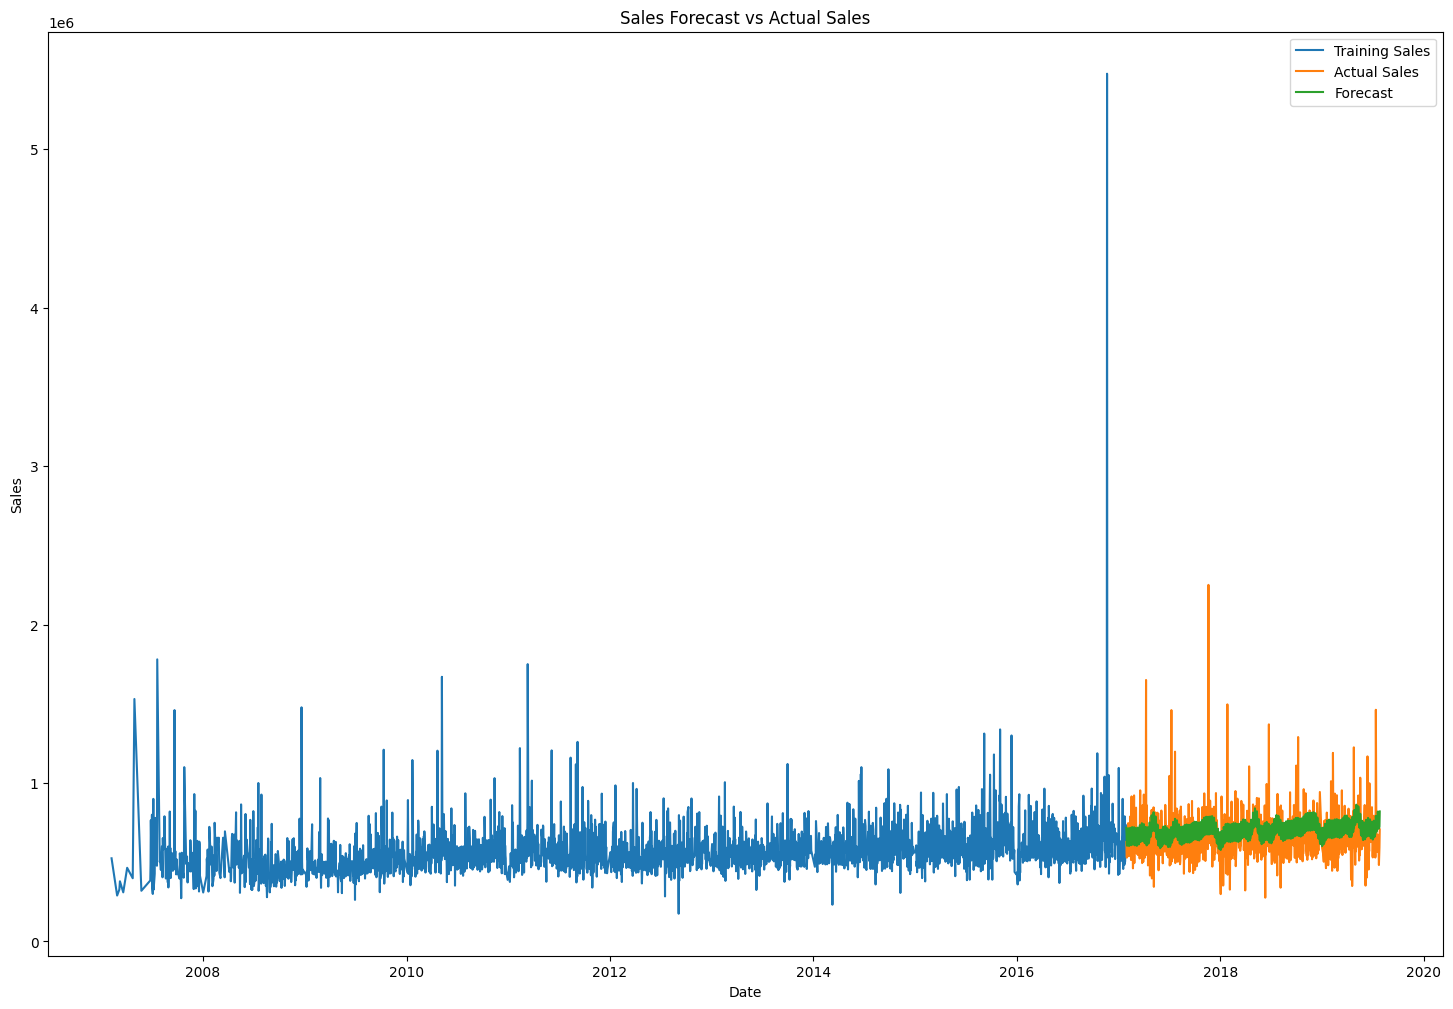

In [231]:
plt.figure(figsize=(18, 12))
sns.lineplot(x=train['ds'], y=train['y'], label='Training Sales')
sns.lineplot(x=test['ds'], y=test['y'], label='Actual Sales')
sns.lineplot(x=forecast['ds'], y=forecast['yhat'], label='Forecast')
plt.title('Sales Forecast vs Actual Sales')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.show()